In [1]:
# CELL 1: Setup Kaggle and Download Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip -o -q amazon-fine-food-reviews.zip -d /content/data

print("✓ Dataset downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 57% 137M/242M [00:00<00:00, 1.43GB/s]
100% 242M/242M [00:00<00:00, 724MB/s] 
✓ Dataset downloaded successfully!


In [2]:

!pip install -q transformers datasets torch scikit-learn pandas numpy matplotlib seaborn wordcloud vaderSentiment textblob xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import gc
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"✓ Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00
✓ All libraries imported successfully!
✓ Using device: cpu


In [3]:

print("\n" + "=" * 80)
print("LOADING DATASET (MEMORY OPTIMIZED)")
print("=" * 80)

# CRITICAL: Sample only first 50,000 rows to prevent crashes
df = pd.read_csv('/content/data/Reviews.csv', nrows=50000)

print(f"✓ Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

# Convert Score to sentiment
def rating_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Score'].apply(rating_to_sentiment)
df['text'] = df['Text']

# Keep only needed columns
df = df[['text', 'sentiment']].copy()

# Remove missing values
df = df.dropna()

# Balance dataset to prevent memory issues
print("\n" + "=" * 40)
print("BALANCING DATASET")
print("=" * 40)

# Take equal samples from each class (max 8000 per class)
min_samples = min(8000, df['sentiment'].value_counts().min())
df_balanced = df.groupby('sentiment').sample(n=min_samples, random_state=42)

print(f"Original size: {len(df)}")
print(f"Balanced size: {len(df_balanced)}")
print(f"\nSentiment distribution:")
print(df_balanced['sentiment'].value_counts())

df = df_balanced
del df_balanced
gc.collect()

print(f"\n✓ Final dataset shape: {df.shape}")


LOADING DATASET (MEMORY OPTIMIZED)
✓ Dataset loaded: (50000, 10)

Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First 3 rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo S


EXPLORATORY DATA ANALYSIS

Sentiment Distribution:
sentiment
negative    4047
neutral     4047
positive    4047
Name: count, dtype: int64

Proportions:
sentiment
negative    0.333333
neutral     0.333333
positive    0.333333
Name: count, dtype: float64

Text Statistics:
          text_length                                                     \
                count        mean         std   min    25%    50%    75%   
sentiment                                                                  
negative       4047.0  476.254015  437.043300  50.0  209.0  350.0  599.5   
neutral        4047.0  515.620707  447.628093  55.0  222.0  383.0  655.0   
positive       4047.0  405.168026  395.828221  60.0  169.0  282.0  486.0   

                  word_count                                                 \
              max      count       mean        std   min   25%   50%    75%   
sentiment                                                                     
negative   6787.0     4047.0  87.1

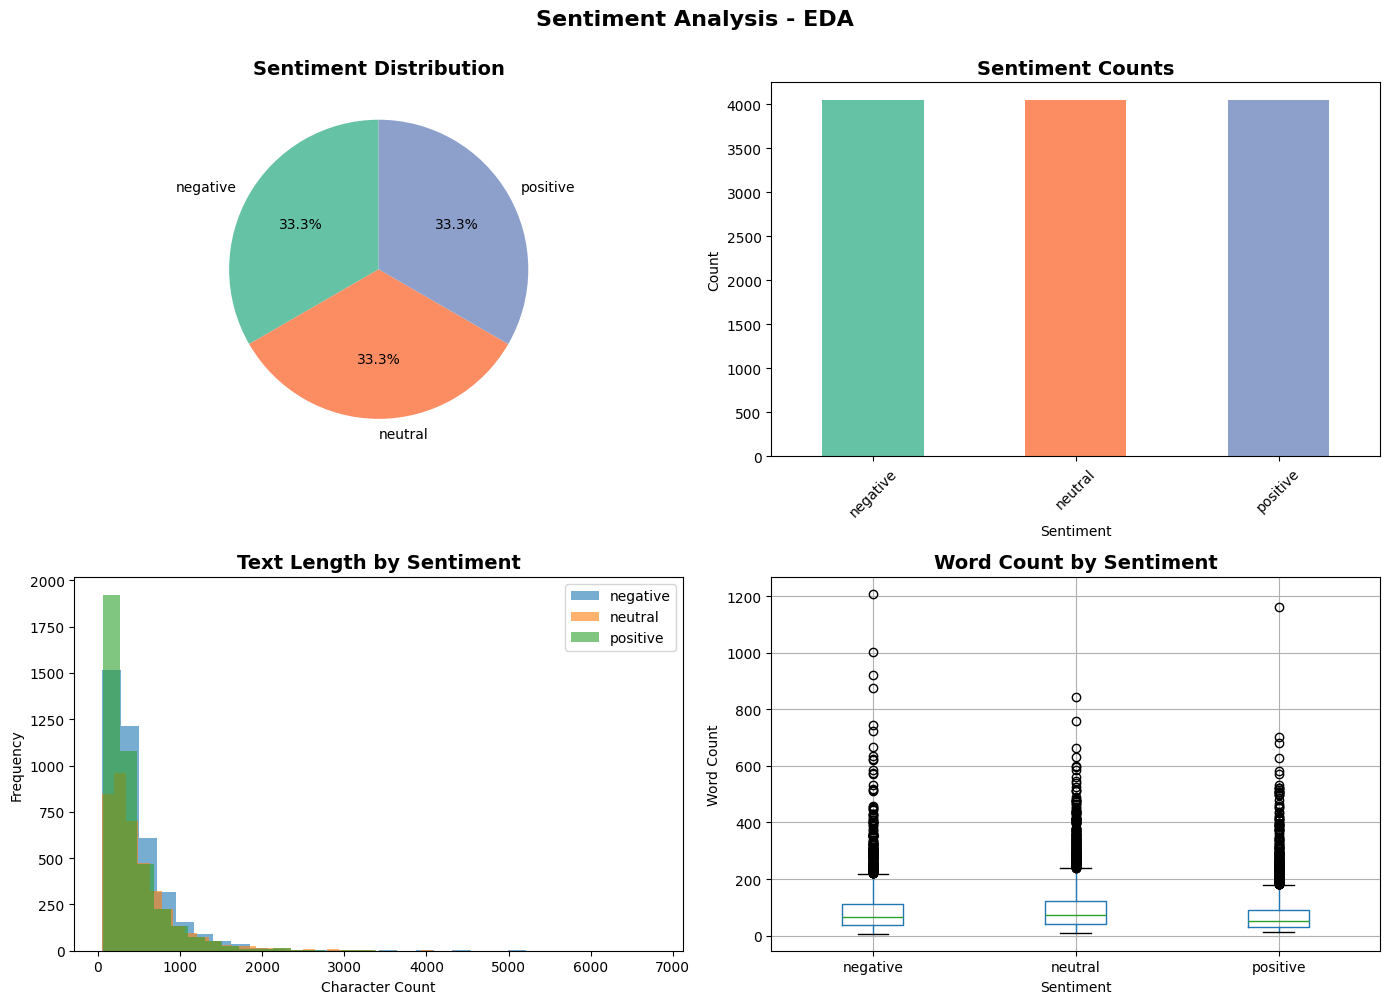

✓ EDA complete!


In [4]:
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
print(f"\nSentiment Distribution:")
print(sentiment_counts)
print(f"\nProportions:")
print(sentiment_counts / len(df))

# Text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"\nText Statistics:")
print(df.groupby('sentiment')[['text_length', 'word_count']].describe())

# Visualization (compact)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment pie chart
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
sentiment_counts.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('')

# 2. Sentiment bar chart
sentiment_counts.plot(kind='bar', ax=axes[0, 1], color=colors)
axes[0, 1].set_title('Sentiment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Text length by sentiment
for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]['text_length']
    axes[1, 0].hist(subset, bins=30, alpha=0.6, label=sentiment)
axes[1, 0].set_title('Text Length by Sentiment', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Word count boxplot
df.boxplot(column='word_count', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Word Count')
plt.sca(axes[1, 1])

plt.suptitle('Sentiment Analysis - EDA', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ EDA complete!")

In [5]:
print("\n" + "=" * 80)
print("TEXT PREPROCESSING")
print("=" * 80)

class SentimentPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep sentiment-bearing words
        self.stop_words -= {'not', 'no', 'nor', 'neither', 'never', 'none'}

    def clean_text(self, text):
        """Clean text while preserving sentiment"""
        text = str(text).lower()

        # Handle contractions
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'ll", " will", text)

        # Remove URLs and emails
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def preprocess(self, text):
        """Full preprocessing pipeline"""
        text = self.clean_text(text)
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]
        return ' '.join(tokens)

# Process in batches to save memory
print("Processing texts...")
preprocessor = SentimentPreprocessor()

# Process in chunks
chunk_size = 1000
cleaned_texts = []

for i in tqdm(range(0, len(df), chunk_size), desc="Preprocessing"):
    chunk = df['text'].iloc[i:i+chunk_size]
    cleaned_chunk = chunk.apply(preprocessor.preprocess)
    cleaned_texts.extend(cleaned_chunk.tolist())

df['cleaned_text'] = cleaned_texts

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 0]

print(f"\n✓ Preprocessing complete!")
print(f"Dataset shape: {df.shape}")

# Show samples
print("\nSample preprocessing results:")
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_text'].iloc[i][:80]}...")

# Clean memory
del cleaned_texts, preprocessor
gc.collect()



TEXT PREPROCESSING
Processing texts...


Preprocessing:   0%|          | 0/13 [00:00<?, ?it/s]


✓ Preprocessing complete!
Dataset shape: (12141, 5)

Sample preprocessing results:

Original: Gum sticks to my teeth and flavor doesn't last long at all.  It's ok for vending...
Cleaned:  gum stick teeth flavor not last long vending machine gum decent price gum not go...

Original: When cooking according to instructions in microwave it keeps making popping nois...
Cleaned:  cooking according instruction microwave keep making popping noise eventually pop...

Original: The question about any product is always, Is it worth it's price? Here, no. THe ...
Cleaned:  question product always worth price tea taste reviewed elsewhere check maybe sta...


56

In [6]:
print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Encode labels
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['sentiment_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nTraining set: {len(X_train)}")
print(f"Test set: {len(X_test)}")
print(f"\nClass distribution in training:")
print(pd.Series(y_train).value_counts())

# OPTIMIZED TF-IDF (reduced features to prevent memory issues)
print("\n" + "=" * 40)
print("TF-IDF Vectorization (Memory Optimized)")
print("=" * 40)

tfidf = TfidfVectorizer(
    max_features=3000,  # Reduced from 8000
    ngram_range=(1, 2),  # Reduced from (1,3)
    min_df=5,
    max_df=0.85,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF shape: {X_train_tfidf.shape}")
print(f"✓ Memory usage: {X_train_tfidf.data.nbytes / 1024**2:.2f} MB")

# Clean up
gc.collect()
print("✓ Feature engineering complete!")



FEATURE ENGINEERING
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

Training set: 9712
Test set: 2429

Class distribution in training:
sentiment_encoded
0    3238
2    3237
1    3237
Name: count, dtype: int64

TF-IDF Vectorization (Memory Optimized)
✓ TF-IDF shape: (9712, 3000)
✓ Memory usage: 2.49 MB
✓ Feature engineering complete!


In [7]:
print("\n" + "=" * 80)
print("MACHINE LEARNING MODELS")
print("=" * 80)

def train_and_evaluate(name, model, X_train, X_test, y_train, y_test):
    """Train and evaluate model"""
    print(f"\n{'=' * 60}")
    print(f"Training {name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ F1-Score: {f1:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    return {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'f1_score': f1
    }

# Define models (optimized for speed and memory)
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=500,
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Linear SVM': LinearSVC(
        C=1.0,
        max_iter=500,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
}

results = {}

# Train all models
for name, model in models.items():
    if name == 'Naive Bayes':
        results[name] = train_and_evaluate(name, model, X_train_tfidf, X_test_tfidf, y_train, y_test)
    else:
        results[name] = train_and_evaluate(name, model, X_train_tfidf, X_test_tfidf, y_train, y_test)

    # Clean memory after each model
    gc.collect()

print(f"\n✓ All ML models trained successfully!")


MACHINE LEARNING MODELS

Training Logistic Regression...
✓ Accuracy: 0.6958
✓ F1-Score: 0.6953

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.70      0.70       809
     neutral       0.62      0.61      0.62       810
    positive       0.76      0.78      0.77       810

    accuracy                           0.70      2429
   macro avg       0.70      0.70      0.70      2429
weighted avg       0.70      0.70      0.70      2429


Training Naive Bayes...
✓ Accuracy: 0.6809
✓ F1-Score: 0.6810

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.67      0.68       809
     neutral       0.61      0.62      0.61       810
    positive       0.75      0.76      0.75       810

    accuracy                           0.68      2429
   macro avg       0.68      0.68      0.68      2429
weighted avg       0.68      0.68      0.68      2429


Training Linear SVM...
✓ Accur

In [8]:
print(f"\n{'=' * 60}")
print("Training Ensemble Model...")

ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=300, C=1.0, random_state=42)),
        ('nb', MultinomialNB(alpha=0.1)),
        ('lgbm', LGBMClassifier(n_estimators=50, max_depth=6, random_state=42, verbose=-1))
    ],
    voting='soft',
    n_jobs=-1
)

results['Ensemble'] = train_and_evaluate('Ensemble', ensemble, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Clean memory
gc.collect()
print(f"\n✓ Ensemble model trained!")


# ============================================================================
# CELL 9: BERT Model (OPTIONAL - MEMORY INTENSIVE)
# ============================================================================

print("\n" + "=" * 80)
print("TRANSFORMER MODEL - BERT (OPTIMIZED)")
print("=" * 80)
print("NOTE: This is memory-intensive. Skip if running low on resources.")
print("=" * 80)

try:
    # Take smaller sample for BERT to prevent crashes
    bert_sample_size = 5000
    X_train_bert = X_train.sample(n=min(bert_sample_size, len(X_train)), random_state=42)
    y_train_bert = y_train[X_train_bert.index]
    X_test_bert = X_test.sample(n=min(1000, len(X_test)), random_state=42)
    y_test_bert = y_test[X_test_bert.index]

    print(f"BERT training samples: {len(X_train_bert)}")
    print(f"BERT test samples: {len(X_test_bert)}")

    # Tokenize
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def encode_texts(texts, max_length=64):
        """Encode texts for BERT"""
        return tokenizer(
            texts.tolist(),
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

    print("Tokenizing texts...")
    train_encodings = encode_texts(X_train_bert)
    test_encodings = encode_texts(X_test_bert)

    # Create datasets
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train_bert.values)
    )
    test_dataset = TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(y_test_bert.values)
    )

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Load model
    num_labels = len(le.classes_)
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
    bert_model.to(device)

    # Training setup
    optimizer = AdamW(bert_model.parameters(), lr=2e-5)
    epochs = 2

    # Training loop
    print("\nTraining BERT...")
    bert_model.train()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        total_loss = 0

        progress_bar = tqdm(train_loader, desc="Training")
        for batch in progress_bar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        print(f"Avg loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    print("\nEvaluating BERT...")
    bert_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    bert_accuracy = accuracy_score(all_labels, all_preds)
    bert_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nBERT Results:")
    print(f"✓ Accuracy: {bert_accuracy:.4f}")
    print(f"✓ F1-Score: {bert_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

    results['BERT'] = {
        'model': bert_model,
        'predictions': np.array(all_preds),
        'accuracy': bert_accuracy,
        'f1_score': bert_f1
    }

    # Clean memory
    del bert_model, train_encodings, test_encodings, train_dataset, test_dataset
    torch.cuda.empty_cache()
    gc.collect()

    print(f"\n✓ BERT training complete!")

except Exception as e:
    print(f"\n⚠️ BERT training skipped due to: {str(e)}")
    print("Continuing with other models...")
    all_labels = y_test  # Fallback for later analysis



Training Ensemble Model...

Training Ensemble...
✓ Accuracy: 0.7056
✓ F1-Score: 0.7049

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.70      0.71       809
     neutral       0.64      0.63      0.63       810
    positive       0.76      0.79      0.77       810

    accuracy                           0.71      2429
   macro avg       0.70      0.71      0.70      2429
weighted avg       0.70      0.71      0.70      2429


✓ Ensemble model trained!

TRANSFORMER MODEL - BERT (OPTIMIZED)
NOTE: This is memory-intensive. Skip if running low on resources.
BERT training samples: 5000
BERT test samples: 1000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing texts...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT...

Epoch 1/2


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Avg loss: 0.8799

Epoch 2/2


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Avg loss: 0.6324

Evaluating BERT...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


BERT Results:
✓ Accuracy: 0.6610
✓ F1-Score: 0.6613

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.76      0.69       338
     neutral       0.56      0.53      0.54       331
    positive       0.81      0.69      0.75       331

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000


✓ BERT training complete!



MODEL COMPARISON

              Model  Accuracy  F1-Score
           Ensemble  0.705640  0.704932
Logistic Regression  0.695760  0.695343
         Linear SVM  0.685879  0.685059
        Naive Bayes  0.680939  0.680980
            XGBoost  0.671881  0.670967
           LightGBM  0.668588  0.667057
               BERT  0.661000  0.661283
      Random Forest  0.635653  0.633181


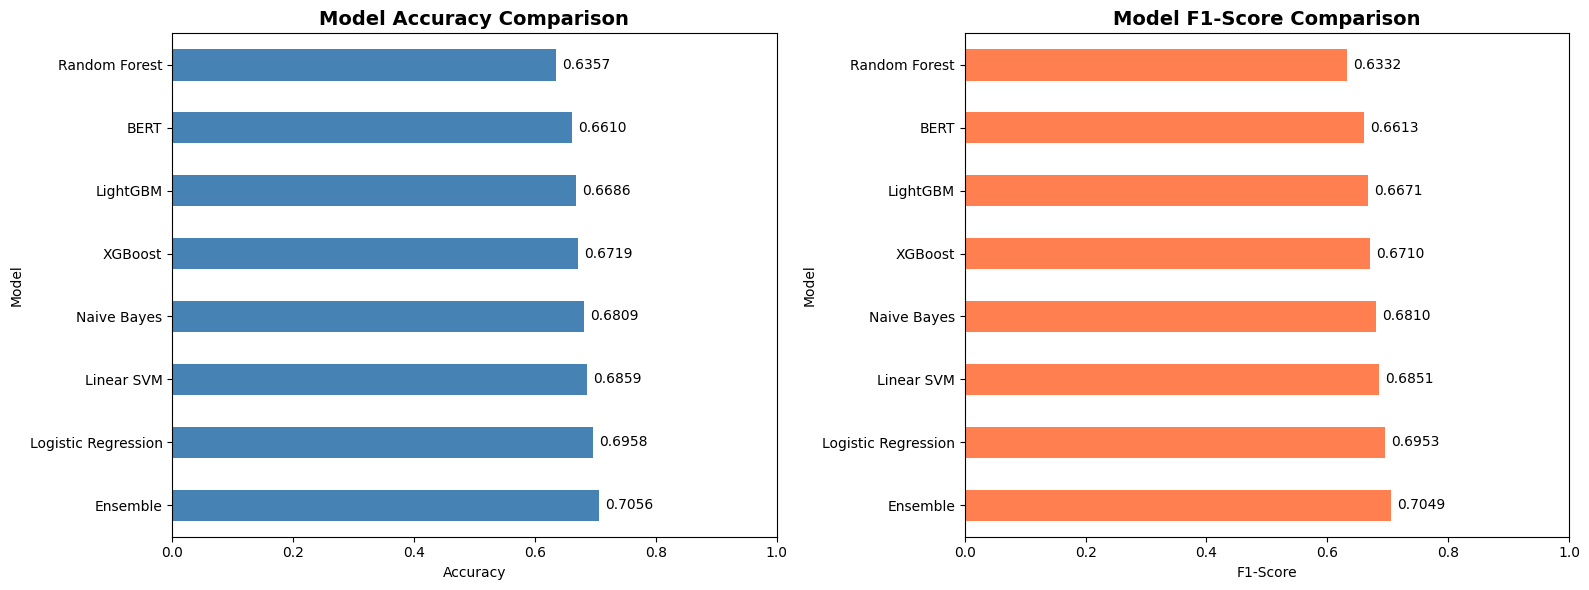


✓ Best Model: Ensemble


In [9]:

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})
comparison = comparison.sort_values('F1-Score', ascending=False)

print("\n" + comparison.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

comparison.plot(x='Model', y='Accuracy', kind='barh', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Accuracy')
ax1.set_xlim(0, 1)
for i, v in enumerate(comparison['Accuracy']):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center')

comparison.plot(x='Model', y='F1-Score', kind='barh', ax=ax2, color='coral', legend=False)
ax2.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('F1-Score')
ax2.set_xlim(0, 1)
for i, v in enumerate(comparison['F1-Score']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

print(f"\n✓ Best Model: {comparison.iloc[0]['Model']}")




DETAILED ANALYSIS
Best Model: Ensemble


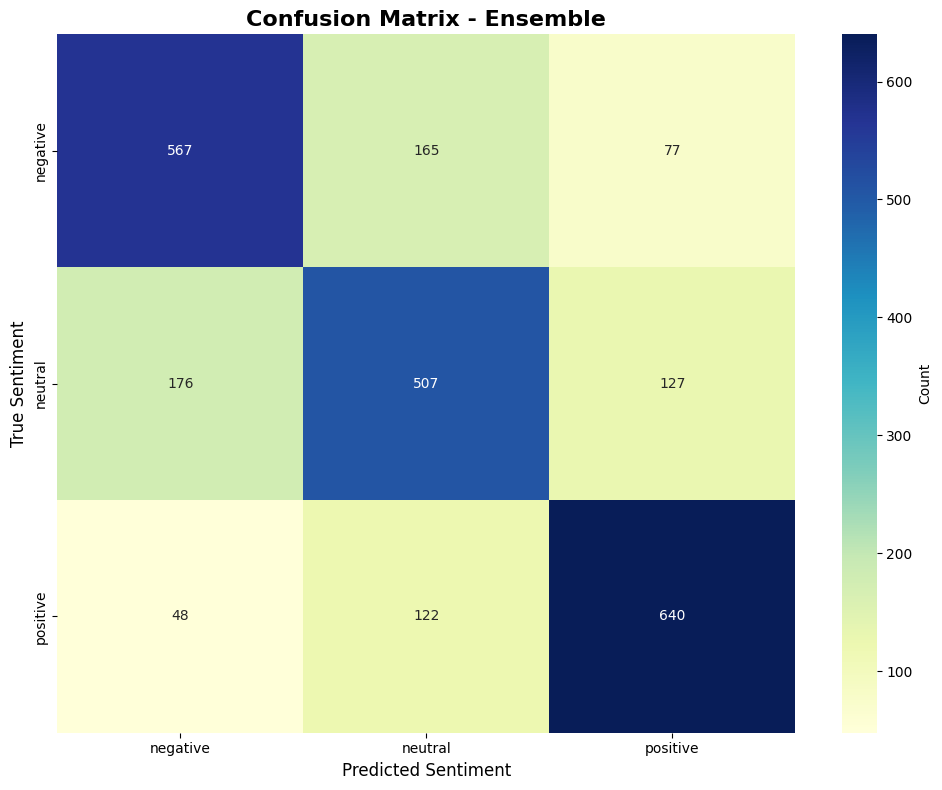

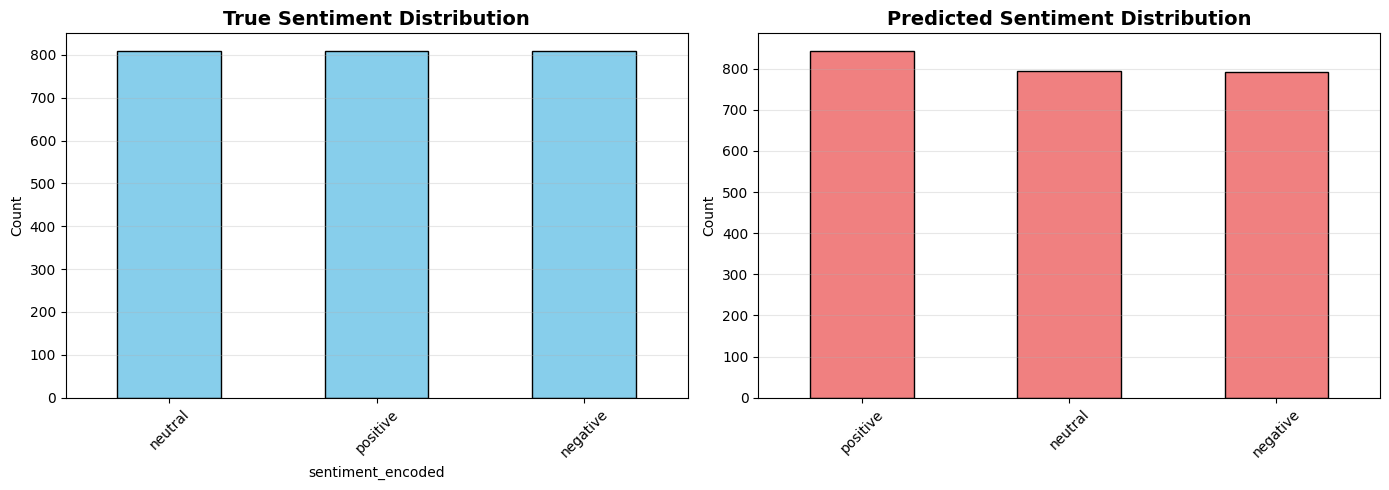


Per-Class Performance:

NEGATIVE:
  Precision: 0.7168
  Recall: 0.7009
  F1-Score: 0.7088

NEUTRAL:
  Precision: 0.6385
  Recall: 0.6259
  F1-Score: 0.6322

POSITIVE:
  Precision: 0.7583
  Recall: 0.7901
  F1-Score: 0.7739

✓ SENTIMENT ANALYSIS COMPLETE!

Summary:
- Dataset size: 12141 samples
- Best model: Ensemble
- Best accuracy: 0.7056
- Best F1-score: 0.7049



In [10]:
print("\n" + "=" * 80)
print("DETAILED ANALYSIS")
print("=" * 80)

best_model_name = comparison.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")

# Get correct y_test based on model
if best_model_name == 'BERT' and 'BERT' in results:
    y_test_for_analysis = all_labels
else:
    y_test_for_analysis = y_test

# Confusion Matrix
cm = confusion_matrix(y_test_for_analysis, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Sentiment', fontsize=12)
plt.xlabel('Predicted Sentiment', fontsize=12)
plt.tight_layout()
plt.show()

# Distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

true_dist = pd.Series(y_test_for_analysis).map(lambda x: le.inverse_transform([x])[0]).value_counts()
pred_dist = pd.Series(best_predictions).map(lambda x: le.inverse_transform([x])[0]).value_counts()

true_dist.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('True Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

pred_dist.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black')
ax2.set_title('Predicted Sentiment Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics per class
print("\nPer-Class Performance:")
for i, class_name in enumerate(le.classes_):
    class_mask_true = y_test_for_analysis == i
    class_mask_pred = best_predictions == i

    tp = np.sum((y_test_for_analysis == i) & (best_predictions == i))
    fp = np.sum((y_test_for_analysis != i) & (best_predictions == i))
    fn = np.sum((y_test_for_analysis == i) & (best_predictions != i))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name.upper()}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n" + "=" * 80)
print("✓ SENTIMENT ANALYSIS COMPLETE!")
print("=" * 80)
print("\nSummary:")
print(f"- Dataset size: {len(df)} samples")
print(f"- Best model: {best_model_name}")
print(f"- Best accuracy: {comparison.iloc[0]['Accuracy']:.4f}")
print(f"- Best F1-score: {comparison.iloc[0]['F1-Score']:.4f}")
print("\n" + "=" * 80)